# Perryman 1998

Differences:
1.  This work will be in equitorial coordinates
2.  No projection  of center motion to candidate members since cluster is so far away at 2kpc
3.  Working only with tangental velocity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
    #trumpler meta data
    trumpler_df = pd.DataFrame([
        ['Trumpler14', '10:43:55.4','-59:32:16', 2.37,0.15, 264, -6.58, 0.06, 2.185, 0.084],
        ['Trumpler15', '10:44:40.8', '-59:22:10', 2.36, 0.09, 320, np.nan, np.nan, np.nan, np.nan],
        ['Trumpler16', '10:45:10.6', '-59:42:28', 2.32,0.12, 320, -6.931,0.063, 2.612, 0.058]
    ], columns=['ClusterName','ra', 'dec','distance','disterr','radius','pm_ra_cosdec','pm_ra_cosdec_error','pm_dec','pm_dec_error']
    ).set_index('ClusterName')
    tc = SkyCoord(ra=trumpler_df.ra, dec=trumpler_df.dec,
        pm_ra_cosdec = list(trumpler_df.pm_ra_cosdec)*u.mas/u.year,
        pm_dec = list(trumpler_df.pm_dec)*u.mas/u.year,
        unit=(u.hourangle, u.deg),
        distance = list(trumpler_df.distance)*u.kpc)
    
    trumpler_coords = {}
    for i, cl in enumerate(trumpler_df.index):
        trumpler_coords[cl]=tc[i]


In [3]:
trumpler_coords['Trumpler15']

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (161.17, -59.36944444, 2.36)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (nan, nan)>

In [4]:
carina_known_members = pd.read_csv('./data/carina_members.csv', comment='#')

In [5]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [6]:

carina_members={}
#for cl in cluster_names:
for cl, cluster in carina_known_members.groupby('Cluster'):
    known_members = list(cluster['Gaia Number'])
    print(f'Fetching {cl}')
    carina_members[cl]  = gs(name = cl, description=f'{cl} sources from Shull table from Gaia eDR3')
    carina_members[cl].from_source_idlist(known_members,schema='gaiaedr3', query_type='sync')

Fetching Bochum11
Fetching Other
Fetching Trumpler14
Fetching Trumpler15
Fetching Trumpler16


In [7]:
carina_members[cl].objs.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'radial_velocity', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'ruwe', 'ra_error', 'dec_error', 'parallax_error',
       'pmra_error', 'pmdec_error', 'radial_velocity_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'r_est'],
      dtype='object')

In [8]:
#carina_cluster_names = list(carina_members.keys())
# can only deal with the Trumplers at the momemnt
carina_cluster_names = ['Trumpler14', 'Trumpler15', 'Trumpler16']

In [9]:
for cl in carina_cluster_names:

    center=trumpler_coords[cl]
    coords = carina_members[cl].get_coords()
    cen_dists = center.separation_3d(coords).to_value(u.pc)
    cen_seps = center.separation(coords).to_value(u.arcsecond)
    carina_members[cl].objs['DistanceFromCenter'] = cen_dists
    carina_members[cl].objs['SeparationFromCenter'] = cen_seps

In [10]:
print('\n--- Min/Max distance of Known Members from Cluster Center ---\n')
for cl in carina_cluster_names:
    print(f'Cluster: {cl}, Min distance: {carina_members[cl].objs.DistanceFromCenter.min():.2f} pc, Max distance: {carina_members[cl].objs.DistanceFromCenter.max():.2f} pc' )


--- Min/Max distance of Known Members from Cluster Center ---

Cluster: Trumpler14, Min distance: 11.60 pc, Max distance: 685.98 pc
Cluster: Trumpler15, Min distance: 23.14 pc, Max distance: 161.58 pc
Cluster: Trumpler16, Min distance: 3.68 pc, Max distance: 390.31 pc


In [11]:
print('\n--- Min/Max distance of Known Members from Cluster Center ---\n')
for cl in carina_cluster_names:
    print(f'Cluster: {cl}, Min Separation: {carina_members[cl].objs.SeparationFromCenter.min():.2f} as, Max Separation: {carina_members[cl].objs.SeparationFromCenter.max():.2f} as' )


--- Min/Max distance of Known Members from Cluster Center ---

Cluster: Trumpler14, Min Separation: 32.84 as, Max Separation: 322.12 as
Cluster: Trumpler15, Min Separation: 50.63 as, Max Separation: 1248.25 as
Cluster: Trumpler16, Min Separation: 43.13 as, Max Separation: 910.22 as


In [12]:
from gaiastars import from_pickle

carina_search_results = from_pickle(f'./data/carina_search_results')

In [15]:
len(carina_search_results), np.isfinite(carina_search_results.objs.radial_velocity).sum()

(107081, 412)

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


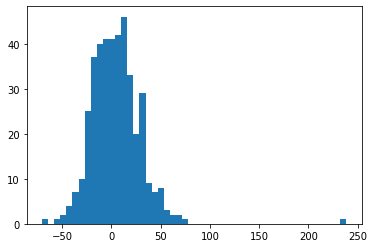

In [16]:
xx = plt.hist(carina_search_results.objs.radial_velocity, bins=50)

In [18]:
(carina_search_results.objs.radial_velocity >= 0).sum(), (carina_search_results.objs.radial_velocity < 0).sum()

(230, 182)

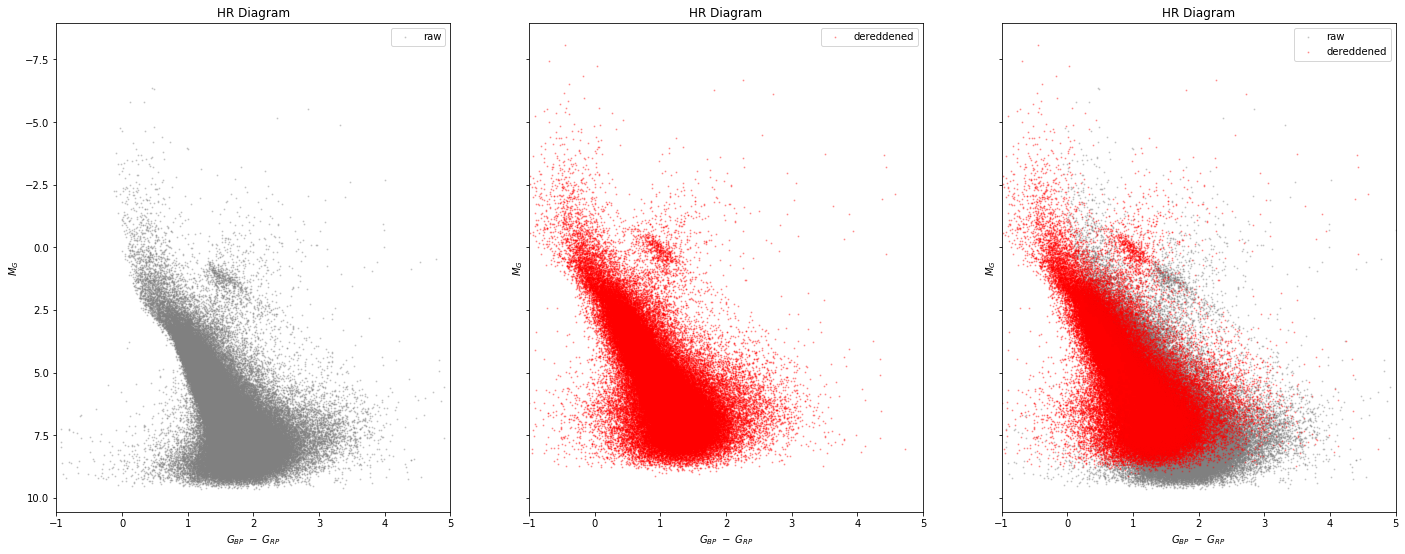

In [13]:
fig = plt.figure(figsize = (24,9))
ax = fig.subplots(1,3, sharex=True, sharey=True)
carina_search_results.plot_hrdiagram(ax=ax[0], color='grey', alpha=0.3, label='raw')
carina_search_results.plot_hrdiagram(ax=ax[1], color='red', alpha=0.3,deredden=True, label='dereddened')

carina_search_results.plot_hrdiagram(ax=ax[2], color='grey', alpha=0.3, label='raw')
carina_search_results.plot_hrdiagram(ax=ax[2], color='red', alpha=0.3,deredden=True, label='dereddened')
for a in ax:
    a.legend()

## Model Code

### Calculations
RA, Dec, PM_RA, PM_DEC calculated as unweighted mean of consitituents.

PM_RA_ERROR and PM_DEC_ERROR to be calculated as Root Means Square of the constituents' PM_RA_Error and PM_Dec_Error where:


$$
RMS(x) = \sqrt{\frac{1}{len(x)} * \sum x^2}
$$
See [Wikipedia](https://en.wikipedia.org/wiki/Root_mean_square)

In [14]:
from src.perryman import perryman

In [18]:
carina_members['Trumpler14'].objs[['pmra','pmra_error','pmdec','pmdec_error', 'radial_velocity', 'radial_velocity_error']]

pmra  pmra_error     pmdec  pmdec_error  \
typed_id                                                           
5350363910256783488 -6.277307    0.019152  2.800635     0.019379   
5350363910256783744 -6.618362    0.020192  2.182186     0.018905   
5350363807162637696 -6.615750    0.015979  2.135090     0.016056   
5350362982528878976 -6.388570    0.033582  3.010798     0.033714   
5350362982543827456 -6.509177    0.028760  2.109449     0.029346   
5350362982543828352 -6.889999    0.029313  1.861610     0.029560   
5350383529668697472 -6.212576    0.015829  2.073719     0.015800   
5350376004884719232 -6.510838    0.014819  2.025330     0.014801   
5350363875896996480 -6.746614    0.013970  1.836732     0.013495   
5350363944616553216 -6.981234    0.023810  1.641925     0.023249   
5350387549760231808 -6.482835    0.019308  2.602925     0.018965   
5350363875897024256 -6.449981    0.011791  2.039142     0.013716   
5350363807177545216 -6.704145    0.015069  2.126229     0.013716   
5350363807177527680 -6.619389    0.018926  2.260758     0.016015   
5350363807162568704 -6.443948    0.016904  2.013618     0.014734   
5350363910241888768 -6.485872    0.015287  2.155955     0.014019   
5350363463580089856 -6.298513    0.015385  1.859282     0.016661   
5350363326141056768 -6.702358    0.016148  2.669729     0.016080   
5350362638946360960 -6.369182    0.021175  2.557349     0.020907   
5350363841537246592 -7.302154    0.014119  1.741311     0.013908   

                     radial_velocity  radial_velocity_error  
typed_id                                                     
5350363910256783488              NaN                    NaN  
5350363910256783744              NaN                    NaN  
5350363807162637696              NaN                    NaN  
5350362982528878976              NaN                    NaN  
5350362982543827456              NaN                    NaN  
5350362982543828352              NaN                    NaN  
5350383529668697472              NaN                    NaN  
5350376004884719232              NaN                    NaN  
5350363875896996480              NaN                    NaN  
5350363944616553216              NaN                    NaN  
5350387549760231808              NaN                    NaN  
5350363875897024256              NaN                    NaN  
5350363807177545216              NaN                    NaN  
5350363807177527680              NaN                    NaN  
5350363807162568704              NaN                    NaN  
5350363910241888768              NaN                    NaN  
5350363463580089856              NaN                    NaN  
5350363326141056768              NaN                    NaN  
5350362638946360960              NaN                    NaN  
5350363841537246592              NaN                    NaN

In [16]:
trumpler14=perryman(carina_members['Trumpler14'].objs,list(carina_members['Trumpler14'].objs.index))

Model initialized with 20 members; Missing members: 0


In [17]:
trumpler14.calculate_center_motion(trumpler14.init_members)

/home/kevin_leo_mcmanus/repos/runawaysearch/src/perryman.py:348: RuntimeWarning: Mean of empty slice.
  d_xyz_3d = d_xyz_m_3d.mean(axis=0)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kevin_leo_mcmanus/repos/runawaysearch/src/perryman.py:349: RuntimeWarning: Degrees of freedom <= 0 for slice
  d_xyz_covar_3d = np.cov(d_xyz_m_3d.reshape(-1,3),rowvar=False)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: Runt

{'d_xyz_2d': array([[ 4.28902051],
        [81.23164872],
        [13.16951252]]),
 'd_xyz_covar_2d': array([[17.64328533,  5.34481662, -8.74890704],
        [ 5.34481662, 67.01869886,  9.77282163],
        [-8.74890704,  9.77282163,  6.7001176 ]]),
 'd_xyz_3d': array([[nan],
        [nan],
        [nan]]),
 'd_xyz_covar_3d': array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])}

In [19]:
t14 = perryman(carina_search_results.objs, list(carina_members['Trumpler14'].objs.index))

Model initialized with 16 members; Missing members: 4


In [20]:
len(carina_search_results)

107081

In [21]:
zz = t14.fit(maxiter=150, max_dist=50)

iterating
/home/kevin_leo_mcmanus/repos/runawaysearch/src/perryman.py:348: RuntimeWarning: Mean of empty slice.
  d_xyz_3d = d_xyz_m_3d.mean(axis=0)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kevin_leo_mcmanus/repos/runawaysearch/src/perryman.py:349: RuntimeWarning: Degrees of freedom <= 0 for slice
  d_xyz_covar_3d = np.cov(d_xyz_m_3d.reshape(-1,3),rowvar=False)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/function_base.py:

Text(0.5, 0.98, 'Proper Motions')

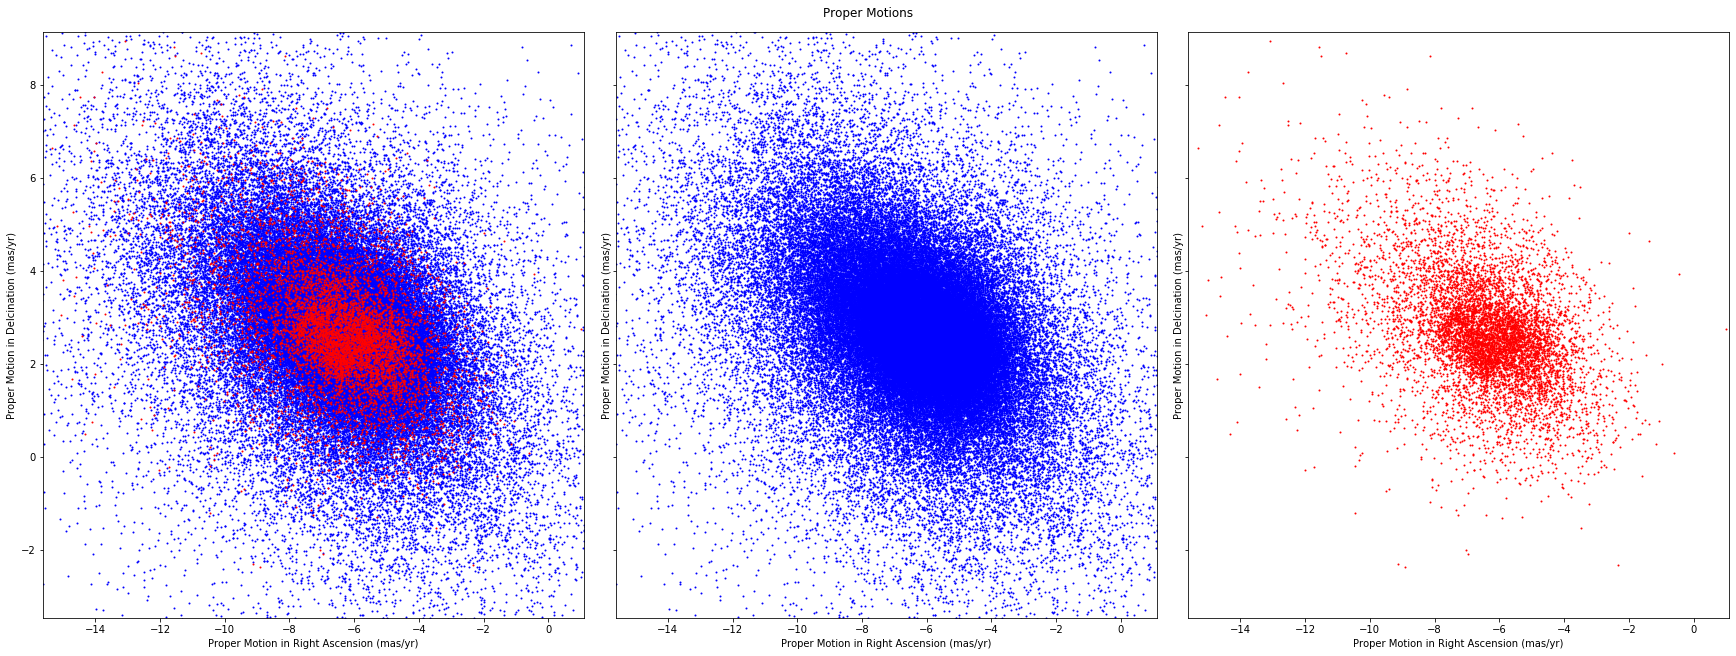

In [22]:
pm_percentile=(0,100)
pm_percentile=(0.5,99.5)

objs=t14.objs
members = t14.members
pmra_percentile = np.percentile(objs.pmra, pm_percentile)
pmdec_percentile = np.percentile(objs.pmdec, pm_percentile)

fig = plt.figure(figsize=(24,9), constrained_layout=True)
axs = fig.subplots(1,3, sharex=True, sharey=True)

axs[0].scatter(objs.pmra[~members], objs.pmdec[~members], s=1, color='blue')
axs[0].scatter(objs.pmra[members], objs.pmdec[members], s=1, color='red')

axs[1].scatter(objs.pmra[~members], objs.pmdec[~members], s=1, color='blue')
axs[2].scatter(objs.pmra[members], objs.pmdec[members], s=1, color='red')

for ax in axs:
    ax.set_xlim(pmra_percentile)
    ax.set_ylim(pmdec_percentile)
    ax.set_ylabel('Proper Motion in Delcination (mas/yr)')
    ax.set_xlabel('Proper Motion in Right Ascension (mas/yr)')
    
plt.suptitle('Proper Motions')


In [31]:
def plot_d_xyz(self, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (km/s)', 'Y Direction (km/s)', 'Z Direction (km/s)']

    for ax,i in zip(axs, cols):
        x = self.objs_d_xyz_2d[:, i[0],:].reshape(-1)
        y = self.objs_d_xyz_2d[:, i[1],:].reshape(-1)
        ax.scatter(x,y, s=1, label='Search Results', color='grey' )
        if hasattr(self,'members') and self.members is not None:
            ax.scatter(x[self.members], y[self.members], color='red', s=1, label='Final Members' )
        if show_rv:
            rv_stars = np.isfinite(self.objs.radial_velocity)
            stars_rv = np.logical_and(self.init_members, rv_stars)
            stars_norv = np.logical_and(self.init_members, ~rv_stars)
            ax.scatter(x[stars_norv], y[stars_norv], color='blue', s=100, label='Initial Members No RV' )
            ax.scatter(x[stars_rv], y[stars_rv], color='magenta', s=100, label='Initial Members RV' )

        else:
            ax.scatter(x[self.init_members], y[self.init_members], color='blue', s=1, label='Initial Members' )

        pm_x_percentile = np.percentile(self.objs_d_xyz_2d[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(self.objs_d_xyz_2d[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Space Velocity')


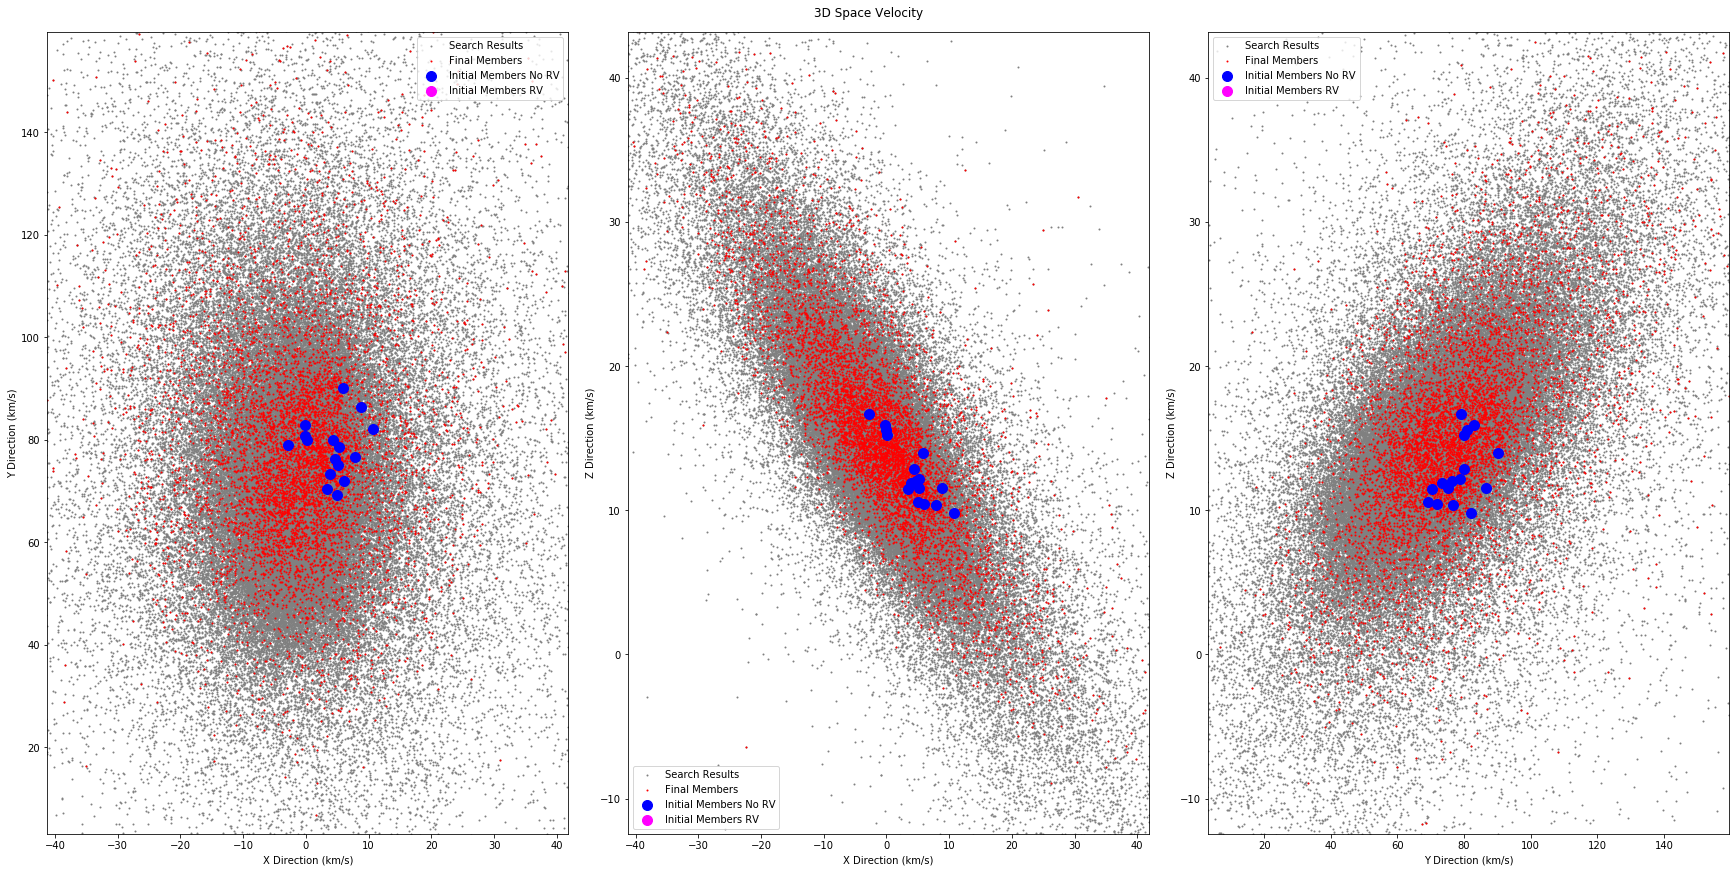

In [32]:
for cl in [t14]:
    fig = plt.figure(figsize=(24,12), constrained_layout=True)
    plot_d_xyz(cl, fig, pm_percentile=(1,99))

In [25]:
fig = plt.figure(figsize=(24,9), constrained_layout=True)
t14.plot(fig, pm_percentile = (0.5,99.5))

KeyError: 'tangental_velocity'

In [23]:
carina_search_results.objs['is_member']=t14.members

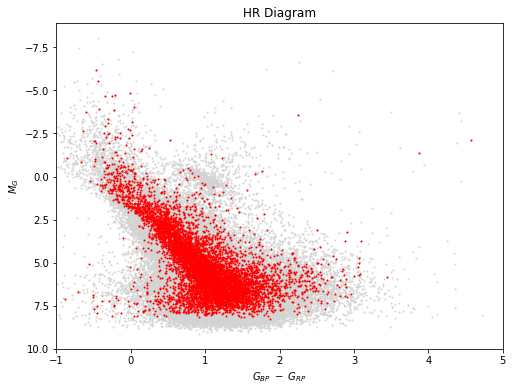

In [24]:
deredden = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
carina_search_results.plot_hrdiagram(ax=ax, color='lightgrey', deredden=deredden)
carina_search_results.query('is_member').plot_hrdiagram(ax=ax, color='red', deredden=deredden)
#carina_search_results.query('is_member').plot_hrdiagram(ax=ax,deredden=True, color='red')

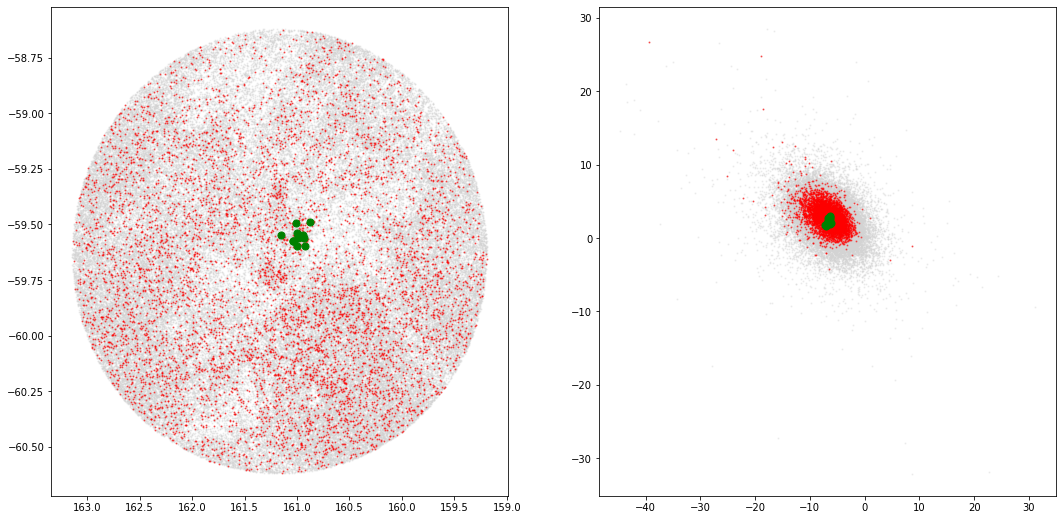

In [38]:
fig = plt.figure(figsize=(18,9))
ax = fig.subplots(1,2)

ax[0].scatter(t14.objs.ra, t14.objs.dec,color='lightgrey',s=1, alpha=0.3)
ax[0].scatter(t14.objs.ra[t14.members], t14.objs.dec[t14.members], color='red',s=1,alpha=0.5)
ax[0].scatter(carina_members['Trumpler14'].objs.ra,carina_members['Trumpler14'].objs.dec, color='green',s=50)

ax[0].invert_xaxis()

ax[1].scatter(t14.objs.pmra, t14.objs.pmdec,color='lightgrey',s=1, alpha=0.3)
ax[1].scatter(t14.objs.pmra[t14.members], t14.objs.pmdec[t14.members], color='red',s=1,alpha=0.5)
ax[1].scatter(carina_members['Trumpler14'].objs.pmra,carina_members['Trumpler14'].objs.pmdec, color='green',s=50)

In [39]:
trumpler_df

ra        dec  distance  disterr  radius  pm_ra_cosdec  \
ClusterName                                                                   
Trumpler14   10:43:55.4  -59:32:16      2.37     0.15     264        -6.580   
Trumpler15   10:44:40.8  -59:22:10      2.36     0.09     320           NaN   
Trumpler16   10:45:10.6  -59:42:28      2.32     0.12     320        -6.931   

             pm_ra_cosdec_error  pm_dec  pm_dec_error  
ClusterName                                            
Trumpler14                0.060   2.185         0.084  
Trumpler15                  NaN     NaN           NaN  
Trumpler16                0.063   2.612         0.058

In [40]:
t15_info = {'ra':161.18, 'ra_error': np.nan,
            'dec':-59.367, 'dec_error': np.nan,
            'parallax': 0.38, 'parallax_error': 0.04,
            'pmra':-6.209, 'pmra_error':0.306,
            'pmdec':2.016, 'pmdec_error':0.216,
            'radial_velocity': -11.6, 'radial_velocity_error':5.8 }
t15_center = pd.Series(t15_info)


In [45]:
t15 = perryman(carina_search_results.objs, init_members=t15_center)

Model initialized with 0 members; Missing members: 0


In [47]:
t15.fit(max_dist=50, maxiter=150)

iterating
Iterations remaining: 0, number of members: 6994


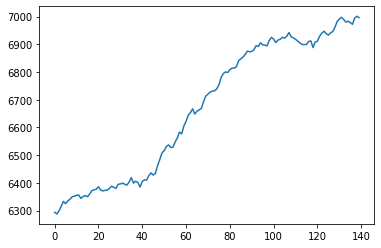

In [52]:
plt.plot(t15.nmembers_iter[10:])

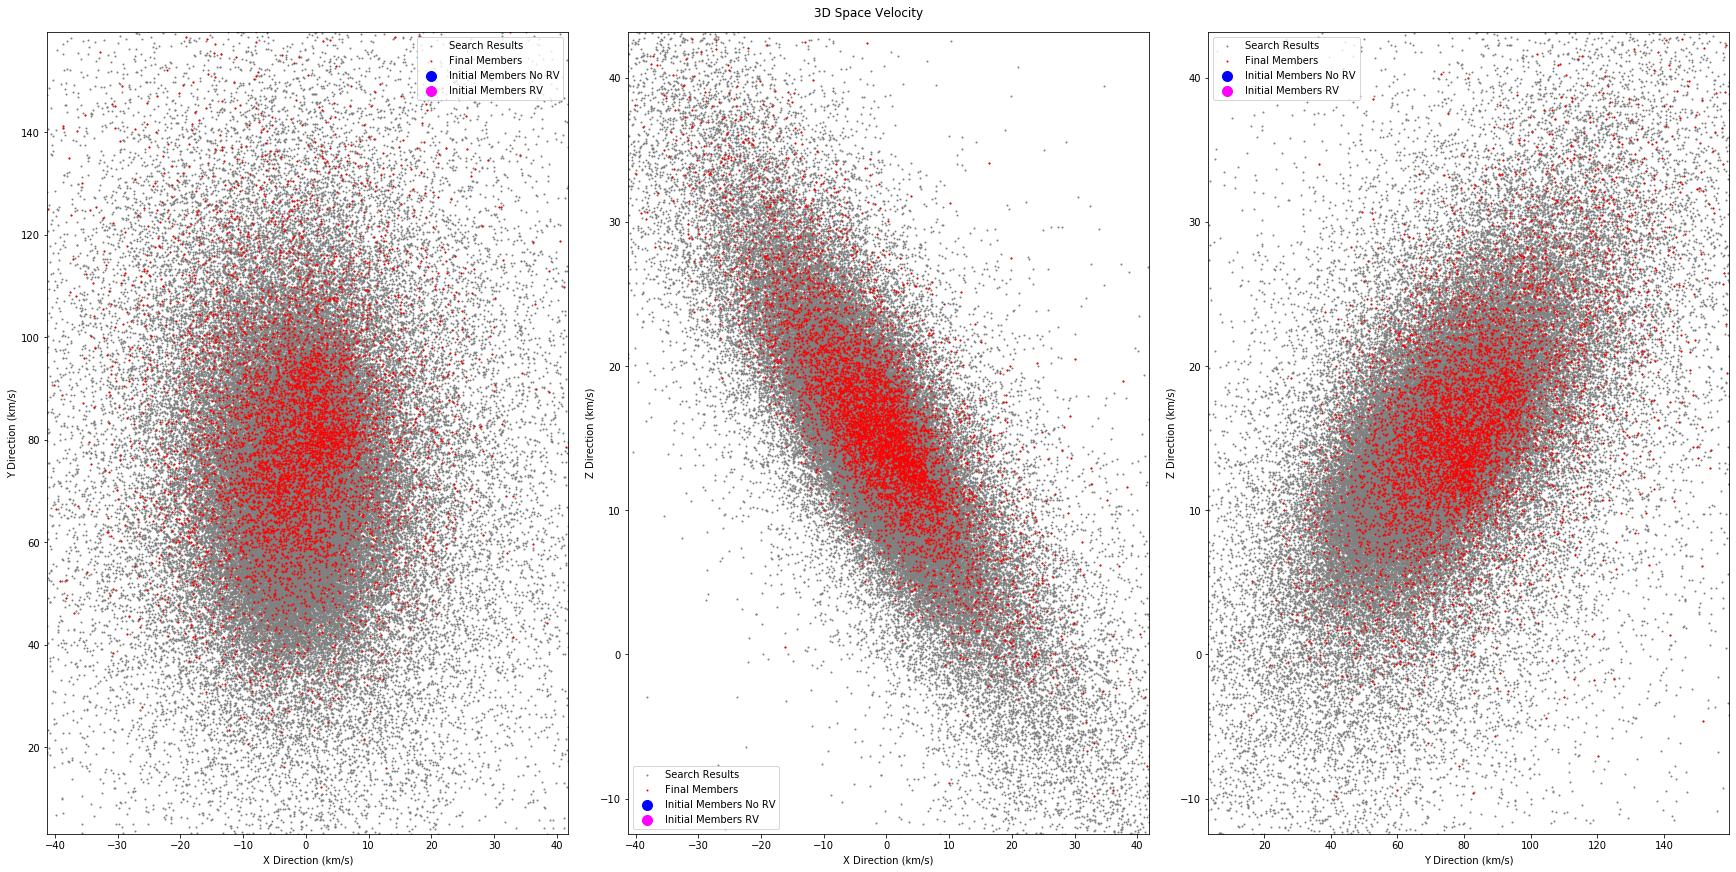

In [53]:
for cl in [t15]:
    fig = plt.figure(figsize=(24,12), constrained_layout=True)
    plot_d_xyz(cl, fig, pm_percentile=(1,99))

In [61]:
def plot_d_xyz(plist, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (km/s)', 'Y Direction (km/s)', 'Z Direction (km/s)']

    for ax,i in zip(axs, cols):
        x0 = plist[0].objs_d_xyz_2d[:, i[0],:].reshape(-1)
        y0 = plist[0].objs_d_xyz_2d[:, i[1],:].reshape(-1)
        x1 = plist[1].objs_d_xyz_2d[:, i[0],:].reshape(-1)
        y1 = plist[1].objs_d_xyz_2d[:, i[1],:].reshape(-1)
        ax.scatter(x0,y0, s=1, label='Search Results', color='lightgrey' )
        if hasattr(plist[0],'members') and plist[0].members is not None:
            ax.scatter(x0[plist[0].members], y0[plist[0].members], color='red', s=1, label='Final Members' )
        if hasattr(plist[1],'members') and plist[1].members is not None:
            ax.scatter(x1[plist[1].members], y1[plist[1].members], color='blue', s=1, label='Final Members' )

        pm_x_percentile = np.percentile(plist[0].objs_d_xyz_2d[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(plist[0].objs_d_xyz_2d[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Space Velocity')

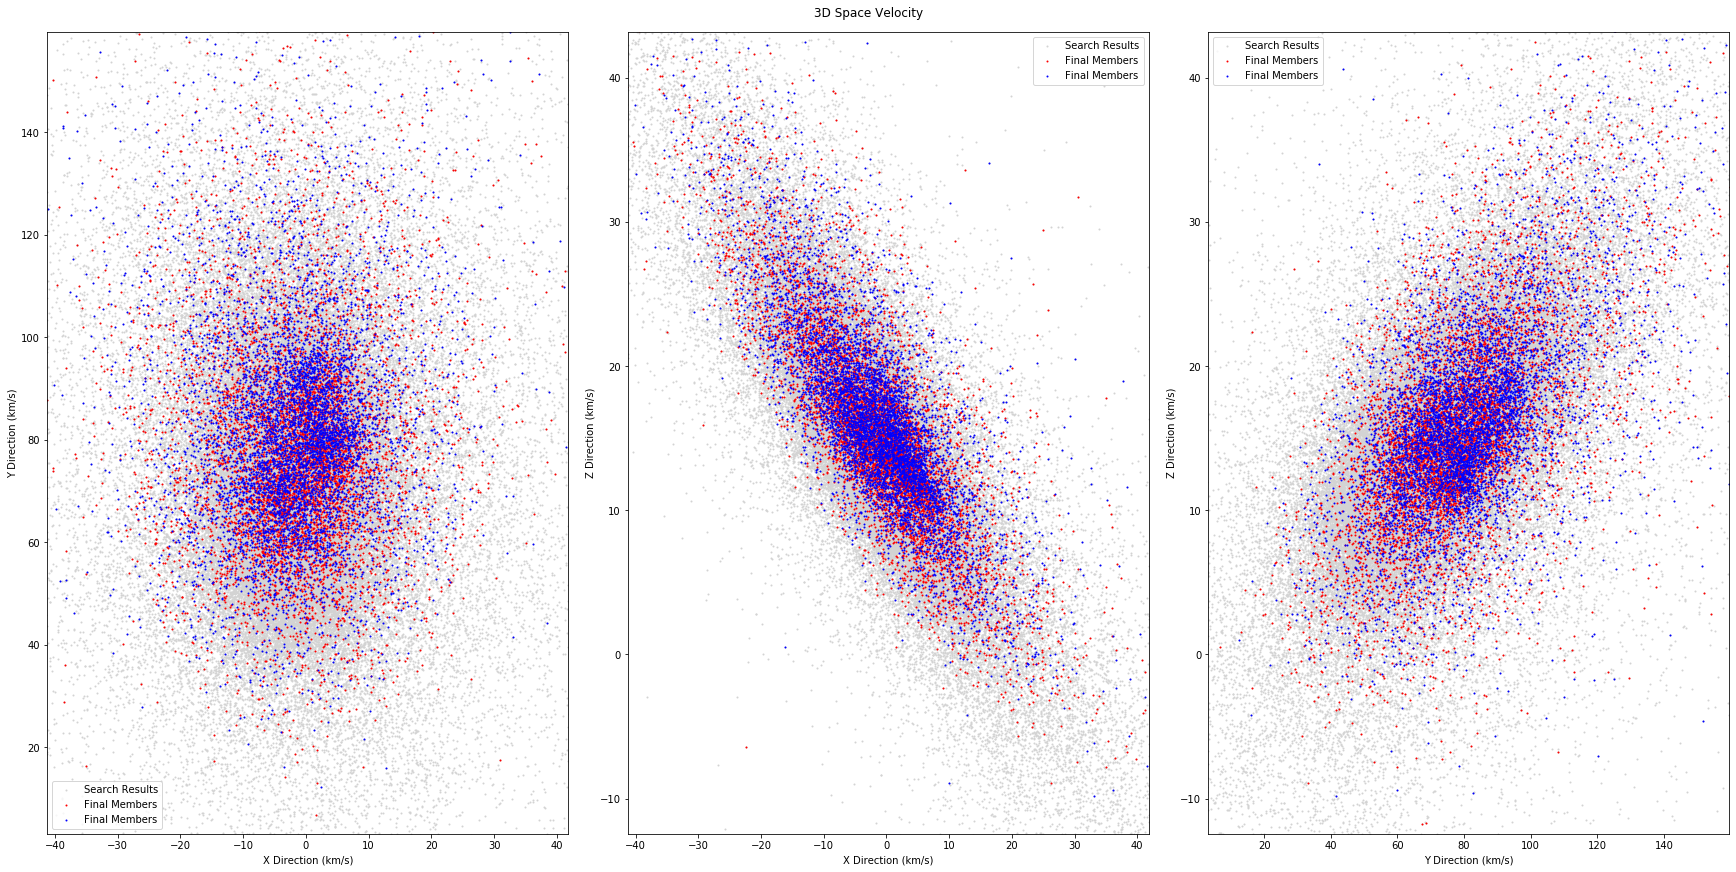

In [62]:
    fig = plt.figure(figsize=(24,12), constrained_layout=True)
    plot_d_xyz([t14,t15], fig, pm_percentile=(1,99))

In [68]:
def plot_xyz(plist, fig, pm_percentile=(0,100), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (km)', 'Y Direction (km)', 'Z Direction (km)']

    for ax,i in zip(axs, cols):
        x0 = plist[0].objs_xyz[:, i[0],:].reshape(-1)
        y0 = plist[0].objs_xyz[:, i[1],:].reshape(-1)
        x1 = plist[1].objs_xyz[:, i[0],:].reshape(-1)
        y1 = plist[1].objs_xyz[:, i[1],:].reshape(-1)
        ax.scatter(x0,y0, s=1, label='Search Results', color='lightgrey' )
        if hasattr(plist[0],'members') and plist[0].members is not None:
            ax.scatter(x0[plist[0].members], y0[plist[0].members], color='red', s=1, label='Final Members' )
        if hasattr(plist[1],'members') and plist[1].members is not None:
            ax.scatter(x1[plist[1].members], y1[plist[1].members], color='blue', s=1, label='Final Members' )

        pm_x_percentile = np.percentile(plist[0].objs_xyz[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(plist[0].objs_xyz[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Position')

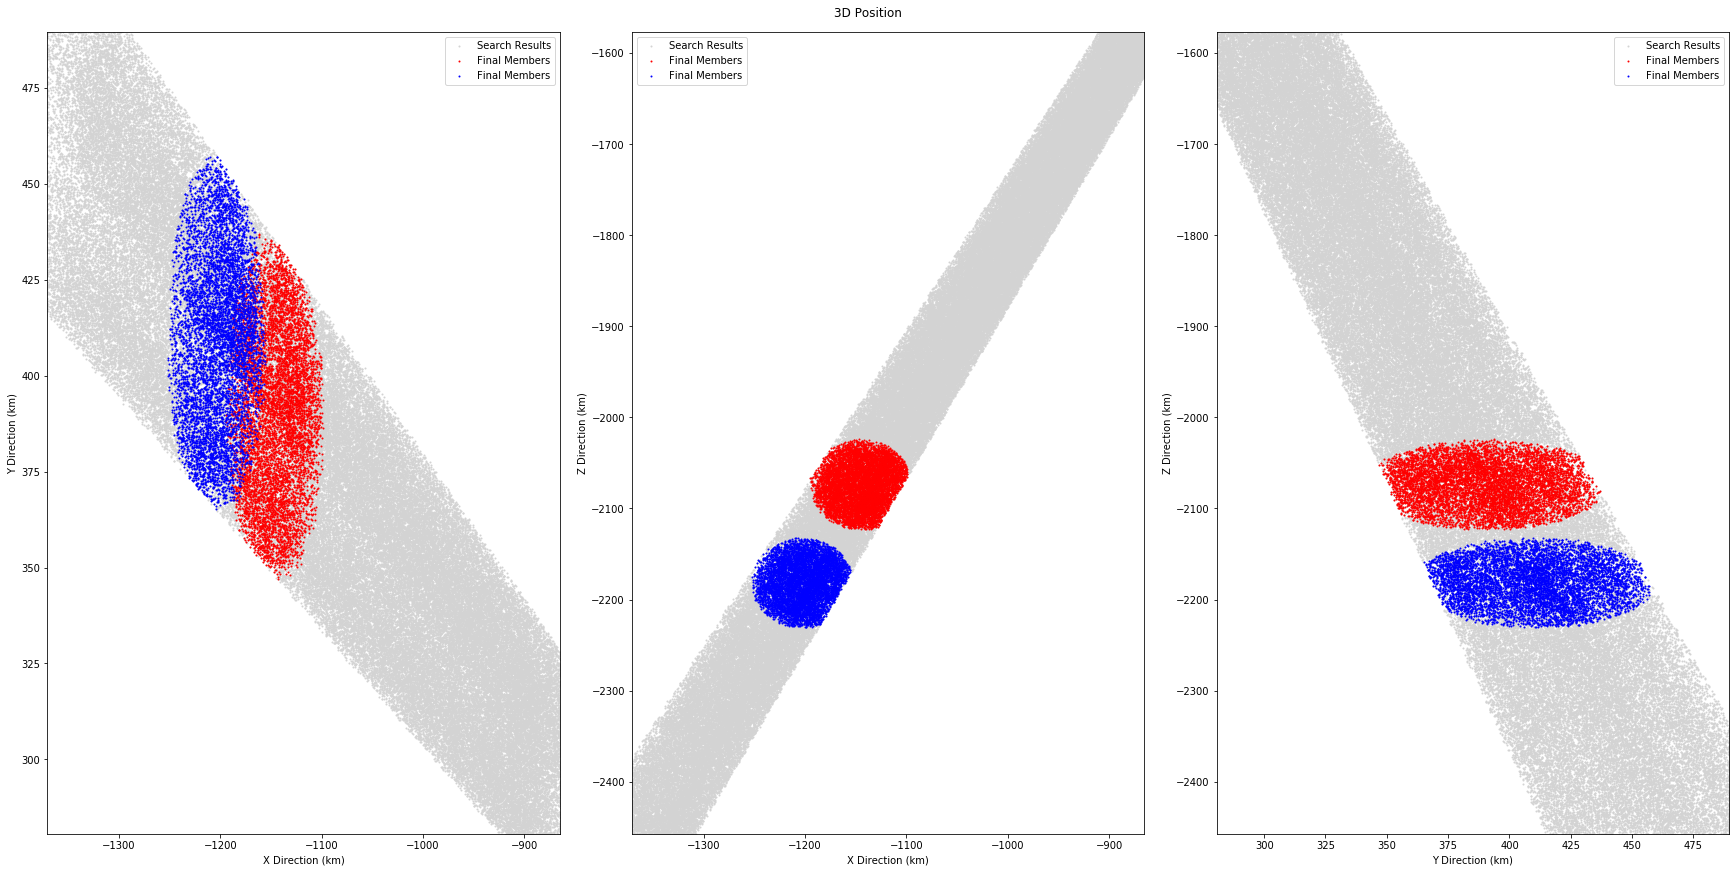

In [69]:
    fig = plt.figure(figsize=(24,12), constrained_layout=True)
    plot_xyz([t14,t15], fig, pm_percentile=(1,99))

In [33]:
carina_members['Trumpler14'].objs[['parallax', 'parallax_error','pmra', 'pmra_error','pmdec','pmdec_error']]

parallax  parallax_error      pmra  pmra_error     pmdec  \
typed_id                                                                        
5350363910256783488  0.403672        0.017538 -6.277307    0.019152  2.800635   
5350363910256783744  0.407265        0.016158 -6.618362    0.020192  2.182186   
5350363807162637696  0.425621        0.014980 -6.615750    0.015979  2.135090   
5350362982528878976  0.384546        0.032281 -6.388570    0.033582  3.010798   
5350362982543827456  0.339924        0.028105 -6.509177    0.028760  2.109449   
5350362982543828352  0.385932        0.028242 -6.889999    0.029313  1.861610   
5350383529668697472  0.434304        0.014177 -6.212576    0.015829  2.073719   
5350376004884719232  0.459950        0.013756 -6.510838    0.014819  2.025330   
5350363875896996480  0.426326        0.012670 -6.746614    0.013970  1.836732   
5350363944616553216  0.360977        0.021732 -6.981234    0.023810  1.641925   
5350387549760231808  0.402731        0.018191 -6.482835    0.019308  2.602925   
5350363875897024256  0.401792        0.011464 -6.449981    0.011791  2.039142   
5350363807177545216  0.364694        0.012715 -6.704145    0.015069  2.126229   
5350363807177527680  0.327228        0.015358 -6.619389    0.018926  2.260758   
5350363807162568704  0.419893        0.014910 -6.443948    0.016904  2.013618   
5350363910241888768  0.435862        0.013448 -6.485872    0.015287  2.155955   
5350363463580089856  0.427000        0.013623 -6.298513    0.015385  1.859282   
5350363326141056768  0.419776        0.015197 -6.702358    0.016148  2.669729   
5350362638946360960  0.385433        0.019049 -6.369182    0.021175  2.557349   
5350363841537246592  0.426960        0.012960 -7.302154    0.014119  1.741311   

                     pmdec_error  
typed_id                          
5350363910256783488     0.019379  
5350363910256783744     0.018905  
5350363807162637696     0.016056  
5350362982528878976     0.033714  
5350362982543827456     0.029346  
5350362982543828352     0.029560  
5350383529668697472     0.015800  
5350376004884719232     0.014801  
5350363875896996480     0.013495  
5350363944616553216     0.023249  
5350387549760231808     0.018965  
5350363875897024256     0.013716  
5350363807177545216     0.013716  
5350363807177527680     0.016015  
5350363807162568704     0.014734  
5350363910241888768     0.014019  
5350363463580089856     0.016661  
5350363326141056768     0.016080  
5350362638946360960     0.020907  
5350363841537246592     0.013908

In [34]:
c15 = trumpler_coords['Trumpler15']
t15 = perryman(carina_search_results.objs,{'ra':c15.ra.to_value(u.degree),'dec':c15.dec.to_value(u.degree),'radius':30})


Model initialized with 21 members; Missing members: 0
calculating velocities and errors
Tangental Velocity Shape: (107081, 2, 1)
Covariance.shape: (107081, 3, 3)
Tangental_velocity_error_covar.shape: (107081, 2, 2)
R.shape: (107081, 3, 2)
objs_dxyz.shape: (107081, 3, 1)
objs_xyz.shape: (107081, 3, 1)
objs_dxyz_covar.shape: (107081, 3, 3)


In [35]:
#t14_pos2, t14_motion2, t14_member2 = t14.fit(maxiter=150, max_dist=50)
t15_pos, t15_motion, t15_members = t15.fit(maxiter=1000, max_dist=50)

iterating
Iterations remaining: 816, number of members: 8488


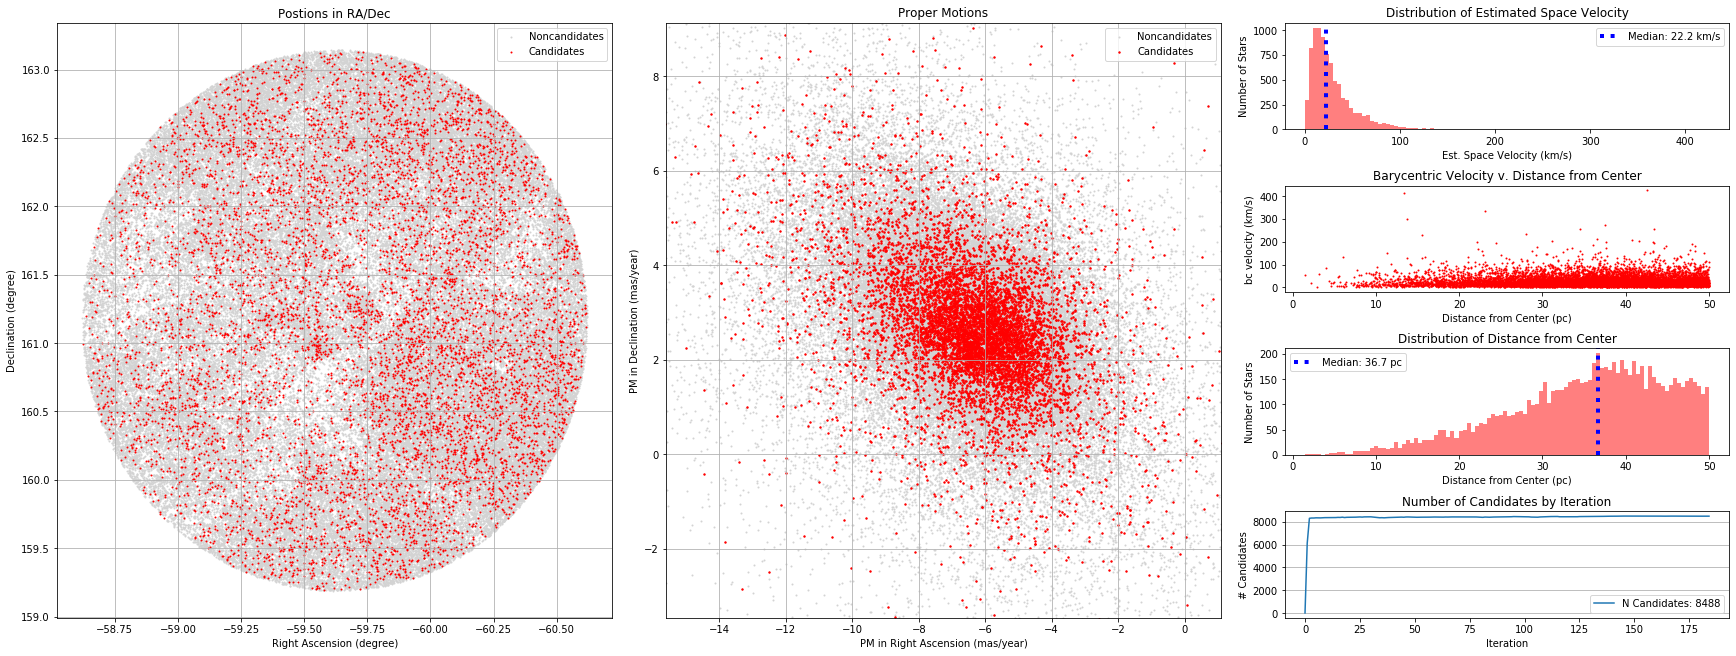

In [36]:
fig = plt.figure(figsize=(24,9), constrained_layout=True)
t15.plot(fig,pm_percentile = (0.5,99.5))

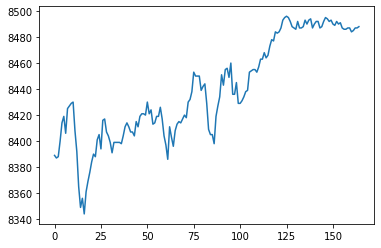

In [37]:
plt.plot(t15.nmembers_iter[20:])


(-3.456366490796243, 9.132566430470517)

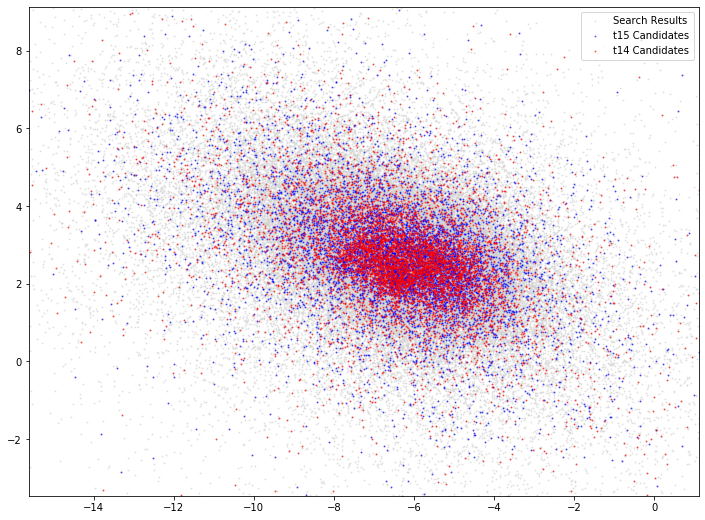

In [38]:
pm_percentile=(0,100)
pm_percentile=(0.5,99.5)
alpha=0.5
pmra_percentile = np.percentile(carina_search_results.objs.pmra, pm_percentile)
pmdec_percentile = np.percentile(carina_search_results.objs.pmdec, pm_percentile)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot()
ax.scatter(carina_search_results.objs.pmra, carina_search_results.objs.pmdec, s=1, alpha=alpha, color='lightgrey',label='Search Results')
ax.scatter(carina_search_results.objs.pmra[t15.members], carina_search_results.objs.pmdec[t15.members], s=1,alpha=alpha, color='blue', label='t15 Candidates')
ax.scatter(carina_search_results.objs.pmra[t14.members], carina_search_results.objs.pmdec[t14.members], s=1,alpha=alpha, color='red', label='t14 Candidates')
#ax.scatter(carina_search_results.objs.pmra[t15.members], carina_search_results.objs.pmdec[t15.members], s=1,alpha=alpha, color='blue', label='t15 Candidates')
ax.legend()
ax.set_xlim(pmra_percentile)
ax.set_ylim(pmdec_percentile)

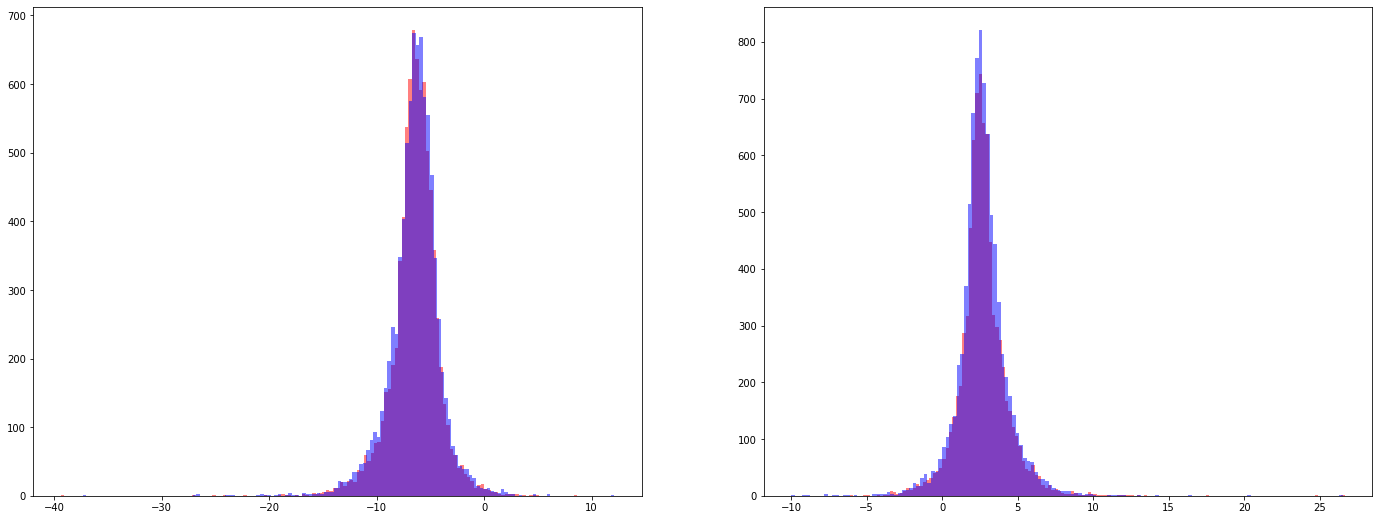

In [40]:
bins = 150
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
alpha=0.5
ax[0].hist(carina_search_results.objs.pmra[t14.members], bins = bins, color='red', alpha=alpha, label='Trumpler 14')
ax[0].hist(carina_search_results.objs.pmra[t15.members], bins = bins, color='blue', alpha=alpha, label='Trumpler 15')

ax[1].hist(carina_search_results.objs.pmdec[t14.members], bins = bins, color='red', alpha=alpha, label='Trumpler 14')
zz=ax[1].hist(carina_search_results.objs.pmdec[t15.members], bins = bins, color='blue', alpha=alpha, label='Trumpler 15')


In [41]:
np.logical_and(t14.members, t15.members).sum(), t14.members.sum(), t15.members.sum()

(25, 8166, 8488)

In [42]:
t14.center_pos

{'xyz': array([[-1144.53926165],
        [  390.08937577],
        [-2072.43799695]]),
 'eq_coords': {'distance': array([2399.40390383]),
  'ra': array([161.17952658]),
  'dec': array([-59.73804362])},
 'R': array([[-0.32260394, -0.81755019],
        [-0.94653404,  0.27864282],
        [ 0.        ,  0.50395423]])}

In [43]:
t15.center_pos

{'xyz': array([[-1098.65675213],
        [  374.90767136],
        [-1989.67224346]]),
 'eq_coords': {'distance': array([2303.56203681]),
  'ra': array([161.15821071]),
  'dec': array([-59.73882229])},
 'R': array([[-0.32295606, -0.81745295],
        [-0.94641396,  0.27894916],
        [ 0.        ,  0.50394249]])}

In [44]:
trumpler_coords['Trumpler15']

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (161.17, -59.36944444, 2.36)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (nan, nan, nan)>